In [2]:
import numpy as np
import pandas as pd
import math as m
import cmath
import sympy as sym
import scipy as sci
import matplotlib.ticker as ticker
import random as rand
import matplotlib.pyplot as plt
import cmath as cm
from sympy import pprint
from scipy.optimize import minimize 
# import MLE_functions as fn
import MLE_functions_numpy as fnn
from MLE_functions_numpy import *
from scipy.optimize import fsolve
import pandas as pd

import warnings     # for suppresing the complex error warnings
warnings.filterwarnings("ignore", message="Casting complex values to real discards the imaginary part")
warnings.filterwarnings("ignore", category=np.ComplexWarning)

In [1]:
"""# Defining two functions specifically for the plotting
def ppm_errors_data(tru, nju_list, ig = 'inv'):  # uses pre-defined function 'ppm errors' on the list of collapse data, creates list of corresponding ppm errors
    
    ppm_errors_list = [fnn.ppm_errors(tru, nju, ig = ig) for nju in nju_list]
    ppm_sums_list = [[sum(i[j]) for j in range(2)] for i in ppm_errors_list]

    ppm_errors_inversion = [i[0] for i in ppm_sums_list]
    ppm_errors_optimization = [i[1] for i in ppm_sums_list]

    return [ppm_errors_inversion, ppm_errors_optimization]


def plot_ppm_errors(error_sum_lists, bins =25, xlim = (None, None), ylim = (None, None)):  # creates histogram and box plot of inversion and optimization ppm errors
    inv = error_sum_lists[0]    # list of ppm errors for inversion and optimization methods
    opt = error_sum_lists[1]    
    
    
    # histogram
    plt.hist([inv, opt], bins=bins, histtype='bar', stacked=False, label=['Inversion', 'Optimization'])
    plt.xlabel('Sum of PPM Errors')
    plt.ylabel('Frequency')
    plt.title('Histogram of Sum of PPM Errors for Inversion and Optimization Methods')
    plt.legend()
    plt.xlim([ xlim[0],xlim[1]]) 
    plt.show()

    # box plot
    plt.boxplot([inv, opt], labels=['Inversion', 'Optimization'], 
                patch_artist=True, 
                boxprops=dict(facecolor='cyan', color='blue'), 
                medianprops=dict(color='red'), 
                whiskerprops=dict(color='green'), 
                capprops=dict(color='magenta'), 
                flierprops=dict(color='yellow', markeredgecolor='black'))
    plt.ylabel('Sum of PPM Errors')
    plt.ylim(ylim[0], ylim[1]) 
    plt.title('Box Plot of Sum of PPM Errors for Inversion and Optimization Methods')
    plt.show()

    # statistical properties
    average_inversion = np.mean(inv)
    average_optimization = np.mean(opt)
    std_dev_inversion = np.std(inv)
    std_dev_optimization = np.std(opt)
    avg_difference = np.sum(np.array(inv) - np.array(opt)) / len(inv)
    std_dev_difference = np.std(np.array(inv) - np.array(opt))
    # print statistical properties
    print(f"Average of PPM Inversion Errors: {average_inversion}")
    print(f"Average of PPM Optimization Errors: {average_optimization}")
    print(f"Standard Deviation of PPM Errors : Inversion Method: {std_dev_inversion}")
    print(f"Standard Deviation of PPM Errors : Optimization Method: {std_dev_optimization}")
    print(f"Average Difference between Optimization and Inversion PPM Errors: {avg_difference}")
    """

'# Defining two functions specifically for the plotting\ndef ppm_errors_data(tru, nju_list, ig = \'inv\'):  # uses pre-defined function \'ppm errors\' on the list of collapse data, creates list of corresponding ppm errors\n    \n    ppm_errors_list = [fnn.ppm_errors(tru, nju, ig = ig) for nju in nju_list]\n    ppm_sums_list = [[sum(i[j]) for j in range(2)] for i in ppm_errors_list]\n\n    ppm_errors_inversion = [i[0] for i in ppm_sums_list]\n    ppm_errors_optimization = [i[1] for i in ppm_sums_list]\n\n    return [ppm_errors_inversion, ppm_errors_optimization]\n\n\ndef plot_ppm_errors(error_sum_lists, bins =25, xlim = (None, None), ylim = (None, None)):  # creates histogram and box plot of inversion and optimization ppm errors\n    inv = error_sum_lists[0]    # list of ppm errors for inversion and optimization methods\n    opt = error_sum_lists[1]    \n    \n    \n    # histogram\n    plt.hist([inv, opt], bins=bins, histtype=\'bar\', stacked=False, label=[\'Inversion\', \'Optimization

# START

## Processing data before plotting
Four different states

*tru1 = [m.pi/6, m.pi/2+m.pi/6, m.pi/4, m.pi/2, m.pi/6]     # 90 deg, non zero phi


*tru2 = [m.pi/12, m.pi/2-m.pi/12, m.pi/4, m.pi/2, m.pi/3]   # 60 deg diff, non zero phi


*tru3 = [m.pi/6, m.pi/3, 0, m.pi/4, m.pi/12]                # 30 deg diff, very uneven alpha 

*tru4 = [m.pi/2+m.pi/12, m.pi/2+ m.pi/6, 0, m.pi/2, m.pi/12] # 15 deg diff, very uneven alpha 

In [3]:
tru1 = [m.pi/6, m.pi/2+m.pi/6, m.pi/4, m.pi/2, m.pi/6]      # 90 deg non zero phi; [30,120,45,90,30]
tru2 = [m.pi/12, m.pi/2-m.pi/12, m.pi/4, m.pi/2, m.pi/3]   # 60 deg diff, non zero phi; [15,75,45,90,60]
tru3 = [m.pi/6, m.pi/3, 0, m.pi/4, m.pi/12]                  # 30 deg diff, very uneven alpha  ; [30,60,0,45,15]
tru4 = [m.pi/2+m.pi/12, m.pi/2+ m.pi/6, 0, m.pi/2, m.pi/12] # 15 deg diff, very uneven alpha ; [105,120,0,90,15]

# Reading collapse data from filenames, and creating lists from the dataframes
file_names = ['collapses_(30 120 45 90 30) 1k 1k.csv', 'collapses_(15 75 45 90 60) 1k 1k.csv','collapses_(30 60 0 45 15) 1k 1k.csv',  'collapses_(105 120 0 90 15) 500 500.csv', 'collapses_(105 120 0 90 15) 20k 100.csv']
dataframes = [pd.read_csv(file_name) for file_name in file_names]
data_list = [df.to_numpy().tolist() for df in dataframes]
nju1, nju2, nju3, nju4_500, nju4_20k = data_list        #lists of the fixed collapse data for each set of true parameters

In [10]:
# creating error lists (~38 minutes) for both inversion initial guess and random initial guess
errors1_inv = ppm_errors_data(tru1, nju1, ig = 'inv')
errors2_inv = ppm_errors_data(tru2, nju2, ig = 'inv')
errors3_inv = ppm_errors_data(tru3, nju3, ig = 'inv')
errors4_500_inv = ppm_errors_data(tru4, nju4_500, ig = 'inv')
errors4_20k_inv = ppm_errors_data(tru4, nju4_20k, ig = 'inv')       # errors for inversion guess

errors1_rand = ppm_errors_data(tru1, nju1, ig = 'rand')
errors2_rand = ppm_errors_data(tru2, nju2, ig = 'rand')
errors3_rand = ppm_errors_data(tru3, nju3, ig = 'rand')
errors4_500_rand = ppm_errors_data(tru4, nju4_500, ig = 'rand')
errors4_20k_rand = ppm_errors_data(tru4, nju4_20k, ig = 'rand')     # errors for random guess, modify lentghs as needed

## Plotting and comparing

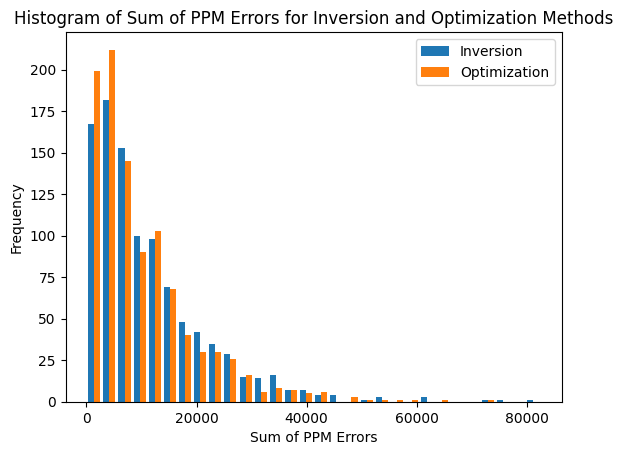

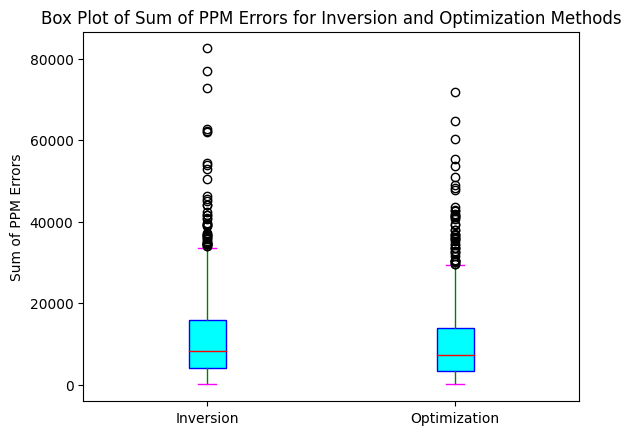

Average of PPM Inversion Errors: 11551.084288721351
Average of PPM Optimization Errors: 10239.24471469563
Standard Deviation of PPM Errors : Inversion Method: 10592.55859889549
Standard Deviation of PPM Errors : Optimization Method: 9582.942884018648
Average Difference between Optimization and Inversion PPM Errors: 1311.8395740257208


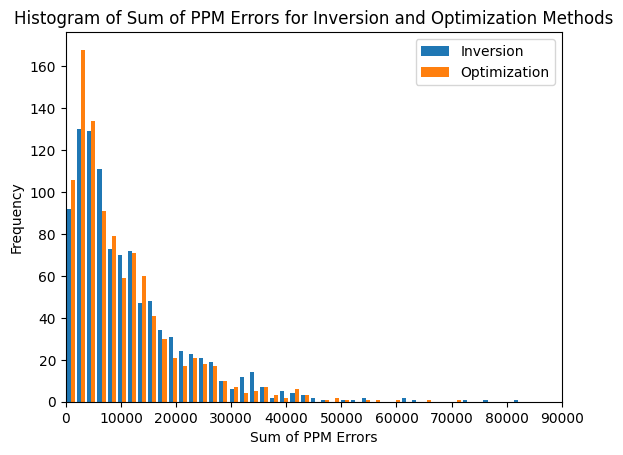

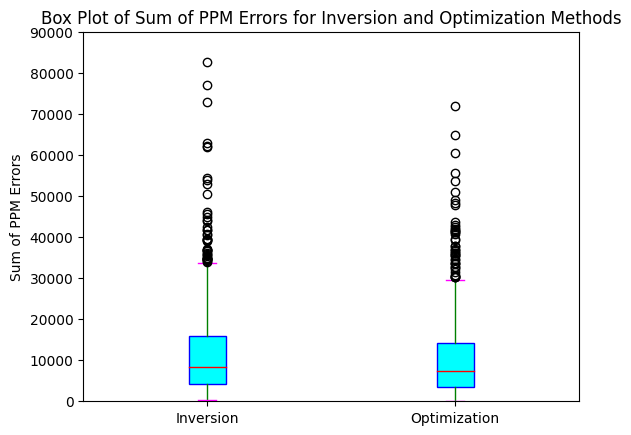

Average of PPM Inversion Errors: 11551.084288721351
Average of PPM Optimization Errors: 19350.780502046302
Standard Deviation of PPM Errors : Inversion Method: 10592.55859889549
Standard Deviation of PPM Errors : Optimization Method: 86879.783190795
Average Difference between Optimization and Inversion PPM Errors: -7799.696213324954


In [19]:
# for tru1 = [m.pi/6, m.pi/2+m.pi/6, m.pi/4, m.pi/2, m.pi/6]      # 90 deg non zero phi; [30,120,45,90,30]

plot_ppm_errors(errors1_inv, bins = 30)
plot_ppm_errors(errors1_rand, bins = 500, xlim = (0, 90000), ylim = (0, 90000))

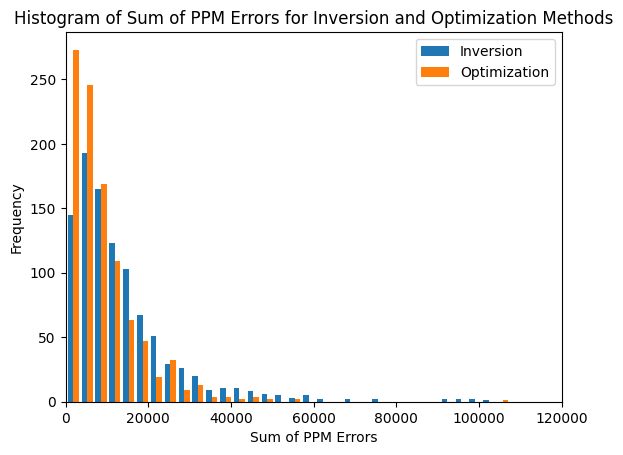

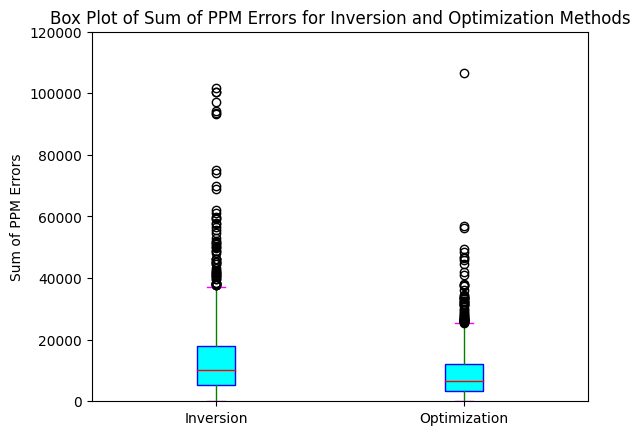

Average of PPM Inversion Errors: 16063.402527822594
Average of PPM Optimization Errors: 9268.959555421132
Standard Deviation of PPM Errors : Inversion Method: 28479.540107588673
Standard Deviation of PPM Errors : Optimization Method: 10086.124184956567
Average Difference between Optimization and Inversion PPM Errors: 6794.44297240146


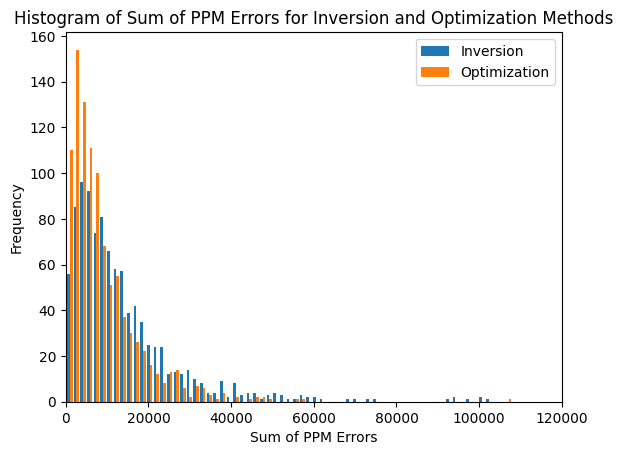

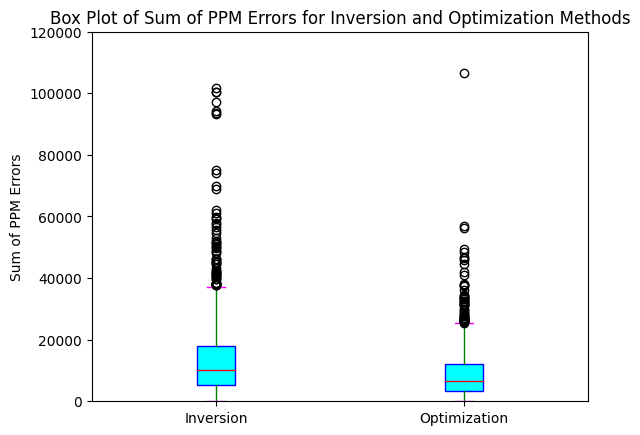

Average of PPM Inversion Errors: 16063.402527822594
Average of PPM Optimization Errors: 10066.872121189077
Standard Deviation of PPM Errors : Inversion Method: 28479.540107588673
Standard Deviation of PPM Errors : Optimization Method: 27074.964309884283
Average Difference between Optimization and Inversion PPM Errors: 5996.530406633517


In [18]:
# tru2
plot_ppm_errors(errors2_inv, bins = 100 , xlim = (0, 120000), ylim = (0, 120000))
plot_ppm_errors(errors2_rand, bins= 500, xlim = (0, 120000), ylim = (0, 120000))